# Sommaire
        
* [Chapitre 1 : Segmentation des données](#chapter1)
    * [Analyse en composante principale](#section_1_1)
        * [Données brut](#section_1_1_1)
        * [Nettoyage des données](#section_1_1_2)
        * [Exportation des données](#section_1_1_3)
    * [K-means sur le jeu de données](#section_1_2)
    * [Classification ascendante hiérarchique](#section_1_3)
    * [Visualisation de la segmentation](#section_1_4)
    * [Représentation des clients types](#section_1_5)
        * [Préparation des radars](#section_1_5_1)
        * [1<sup>ère</sup> segmentation](#section_1_5_2)
        * [2<sup>ème</sup> segmentation](#section_1_5_3)
        * [3<sup>ème</sup> segmentation](#section_1_5_4)

* [Chapitre 2 : Maintenance](#chapter2)
    * [Préparation des données](#section_2_1)
    * [Score ARI](#section_2_2)
    * [Données de maintenance](#section_2_3)
        * [Préparation des données](#section_2_3_1)
        * [Score ARI](#section_2_3_2)    

<a class="anchor" id="chapter1"></a>
# Chapitre 1 : Segmentation des données bruts
<a class="anchor" id="section_1_1"></a>
## Analyse en composante principale

Nous commencons notre étude sur la clusterisation par importer les librairies et les données nettoyées dans le notebook précédent.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import itertools
import datetime
from itertools import chain
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn import model_selection, preprocessing, metrics, manifold
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score, rand_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from functools import reduce
from matplotlib.collections import LineCollection
from matplotlib import colors
from matplotlib.lines import Line2D

data_olist_raw = pd.read_csv("data_olist_raw_projet_5.csv", low_memory=False, index_col=0)
data_maintenance = pd.read_csv("olist_maintenance_raw_projet_5.csv", low_memory=False, index_col=0)

In [2]:
col_client = ['monetary', 'total_products', 'nbr_category', 'review_score',
              'main_category_Electronics', 'main_category_House', 'main_category_Sport_leisure', "main_category_Health_body",
              'heure_commande_Resting_hours', 'heure_commande_Working_hours', 
              'holidays_No', 'holidays_Yes']

col_categ_simple = ['Monétaire', "Nbr\nd'articles", "Nbr\ncatégorie", "Note", 
                    'Electronique', 'Maison', 'Sport\nloisirs', "Santé\nCorps",
                    'Heures\nnon ouvrées', 'Heures\nouvrées', 
                    'Travail', 'Vacances']

rob_scale = preprocessing.RobustScaler()

X_olist_fit = rob_scale.fit_transform(data_olist_raw[col_client].values)

In [3]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 

    # Extrait x et y 
    x, y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(7, 7))
    
    couleurs = ["limegreen", "royalblue", "black", "magenta", "deepskyblue", "forestgreen", "goldenrod", "crimson",
                "grey", "indianred", "orange", "pink"]*4

    style_lignes = ["solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid",
                    "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", 
                    "dotted", "dotted",
                    "dashed", "dashed", "dashed", "dashed", "dashed", "dashed", "dashed", "dashed", "dashed", "dashed", 
                    "dashed", "dashed",
                    "dashdot", "dashdot", "dashdot", "dashdot", "dashdot", "dashdot", "dashdot", "dashdot", "dashdot", 
                    "dashdot", "dashdot", "dashdot"]
    
    important_feature = []
    important_color = []
    important_style_lignes = []
    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                 pca.components_[x, i],  
                 pca.components_[y, i],  
                 head_width=0.04,
                 head_length=0.04, 
                 #width=0.007,
                 linewidth=3,
                 color = couleurs[i],
                 ls = style_lignes[i])

        # Les labels
        if (np.abs(pca.components_[x, i])>0.2) | (np.abs(pca.components_[y, i])>0.2) :
            important_feature.append(features[i])
            important_color.append(couleurs[i])
            important_style_lignes.append(style_lignes[i])
            if ((pca.components_[x, i])<0) & ((pca.components_[y, i])<0) :
                plt.text(pca.components_[x, i] + 0.08,
                         pca.components_[y, i] - 0.08,
                         features[i],
                         color = couleurs[i],
                         fontsize = 10,
                         weight="bold",
                         horizontalalignment="left")
            
            elif ((pca.components_[x, i])>0) & ((pca.components_[y, i])<0) :
                plt.text(pca.components_[x, i] + 0.05,
                         pca.components_[y, i] - (0.03-0.0006/((i+2)*0.006)),
                         features[i],
                         color = couleurs[i],
                         fontsize = 10,
                         weight="bold",
                         horizontalalignment="left")
            elif ((pca.components_[x, i])>0) & ((pca.components_[y, i])>0) :
                plt.text(pca.components_[x, i] + 0.05,
                         pca.components_[y, i] - 0.1,
                         features[i],
                         color = couleurs[i],
                         fontsize = 10,
                         weight="bold",
                         horizontalalignment="left")
                
            elif ((pca.components_[x, i])<0) & ((pca.components_[y, i])>0) :
                plt.text(pca.components_[x, i] + 0.05,
                         pca.components_[y, i] + 0.08,
                         features[i],
                         color = couleurs[i],
                         fontsize = 10,
                         weight="bold",
                         horizontalalignment="left")

        
    custom_lines = []
    
    for i in range (0, len(important_feature), 1):
        custom_lines.append(Line2D([0], [0], color=important_color[i], linestyle=important_style_lignes[i], lw=4))
       
 
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({} %)'.format(x+1, round(100*pca.explained_variance_ratio_[x])),fontsize = 16)
    plt.ylabel('F{} ({} %)'.format(y+1, round(100*pca.explained_variance_ratio_[y])),fontsize = 16)


    # Titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1), fontsize = 18)

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an), c="black")  # Add a unit circle for scale

    # Axes et affichage
    plt.axis('scaled')
    plt.legend(custom_lines, important_feature, frameon=False, bbox_to_anchor=(1, 1), fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show(block=False)

In [4]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[7,7], 
                                marker="." ):
    
    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,7)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1,figsize=(7,6))

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    plt.scatter(   X_[:, x], 
                        X_[:, y], 
                        alpha=alpha, 
                        c="grey", 
                        cmap="Set1", 
                        marker=marker)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} ({v1})', fontsize = 16)
    ax.set_ylabel(f'F{y+1} ({v2})', fontsize = 16)

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1
    
    # Pourcentage de valeurs dans chaque quart (Nord-Est, Sud-Est, Nord-Ouest et Sud-Ouest) de la projection
    n_e = np.where(((X_projected[:,x])>0) & ((X_projected[:,y])>0))
    n_e_list = list(chain.from_iterable(n_e))

    s_e = np.where(((X_projected[:,x])>0) & ((X_projected[:,y])<0))
    s_e_list = list(chain.from_iterable(s_e))

    n_o = np.where(((X_projected[:,x])<0) & ((X_projected[:,y])>0))
    n_o_list = list(chain.from_iterable(n_o))

    s_o = np.where(((X_projected[:,x])<0) & ((X_projected[:,y])<0))
    s_o_list = list(chain.from_iterable(s_o))

    n_n = np.where(((X_projected[:,x])==0) | ((X_projected[:,y])==0))
    n_n_list = list(chain.from_iterable(n_n))
    
    
    nbr_n_e = round(len(n_e_list)*100/len(X_projected),1)
    nbr_s_e = round(len(s_e_list)*100/len(X_projected),1)
    nbr_n_o = round(len(n_o_list)*100/len(X_projected),1)
    nbr_s_o = round(len(s_o_list)*100/len(X_projected),1)
    
    # Affichage de ces pourcentages dans leurs quarts respectifs 
    plt.text(0.75*x_max, 0.9*y_max, f"{round(nbr_n_e,3)}%", color = "firebrick", fontsize = 14)
    plt.text(0.75*x_max, -0.95*y_max, f"{round(nbr_s_e,3)}%", color = "firebrick", fontsize = 14)
    plt.text(-0.95*x_max, 0.9*y_max, f"{round(nbr_n_o,3)}%", color = "firebrick", fontsize = 14)
    plt.text(-0.95*x_max, -0.95*y_max, f"{round(nbr_s_o,3)}%", color = "firebrick", fontsize = 14)

    # On borne x et y 
    ax.set_xlim(left = -x_max, right = x_max)
    ax.set_ylim(bottom = -y_max, top = y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color = 'grey', alpha = 0.8)
    plt.plot([0,0], [-y_max, y_max], color = 'grey', alpha = 0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize = '14', ha = 'center',va='center') 
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})", fontsize = 18)
    plt.show()

array([6.553e+01, 1.146e+01, 9.280e+00, 8.690e+00, 4.220e+00, 3.800e-01,
       2.900e-01, 9.000e-02, 5.000e-02, 1.000e-02, 0.000e+00, 0.000e+00])

array([ 66.,  77.,  86.,  95.,  99., 100., 100., 100., 100., 100., 100.,
       100.])

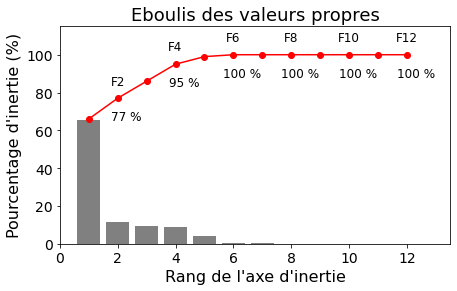

In [5]:
names = data_olist_raw[col_client].index
features = col_categ_simple

n_components = len(col_client)
pca = PCA(n_components=n_components)
pca.fit(X_olist_fit)

pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
display(scree)
scree_cum = scree.cumsum().round()
display(scree_cum)


x_list = range(1, n_components+1)
list(x_list)

plt.figure(figsize=(7,4))

plt.bar(x_list, scree, color="gray")
plt.plot(x_list, scree_cum,c="red",marker='o')

plt.xlabel("Rang de l'axe d'inertie", fontsize=16)
plt.ylabel("Pourcentage d'inertie (%)",fontsize=16)

plt.xticks(np.arange(0,21,2), fontsize=14)
plt.yticks(fontsize=14)

plt.title("Eboulis des valeurs propres", fontsize=18)

plt.xlim(0,13.5)
plt.ylim(0,115)

for a,b in zip(x_list[1::2], scree_cum[1::2]): 
    plt.text(a+0.3, b-10, f"{int(b)} %", fontsize=12, va="center", ha="center", 
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='1'))
    plt.text(a, b+9, f"F{int(a)}",fontsize=12, va="center", ha="center", 
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='1'))

plt.show(block=False)

pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]


array([65.53, 11.46,  9.28,  8.69,  4.22,  0.38])

array([ 66.,  77.,  86.,  95.,  99., 100.])

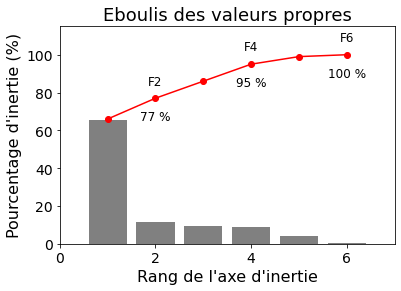

In [6]:
names = data_olist_raw[col_client].index
features = col_categ_simple

n_components = 6
pca = PCA(n_components=n_components)
pca.fit(X_olist_fit)

pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
display(scree)
scree_cum = scree.cumsum().round()
display(scree_cum)


x_list = range(1, n_components+1)
list(x_list)

plt.figure(figsize=(6,4))

plt.bar(x_list, scree, color="gray")
plt.plot(x_list, scree_cum,c="red",marker='o')

plt.xlabel("Rang de l'axe d'inertie", fontsize=16)
plt.ylabel("Pourcentage d'inertie (%)",fontsize=16)

plt.xticks(np.arange(0,21,2), fontsize=14)
plt.yticks(fontsize=14)

plt.title("Eboulis des valeurs propres", fontsize=18)

plt.xlim(0,7)
plt.ylim(0,115)

for a,b in zip(x_list[1::2], scree_cum[1::2]): 
    plt.text(a, b-10, f"{int(b)} %", fontsize=12, va="center", ha="center", 
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='1'))
    plt.text(a, b+9, f"F{int(a)}",fontsize=12, va="center", ha="center", 
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='1'))
    
plt.show(block=False)

pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]

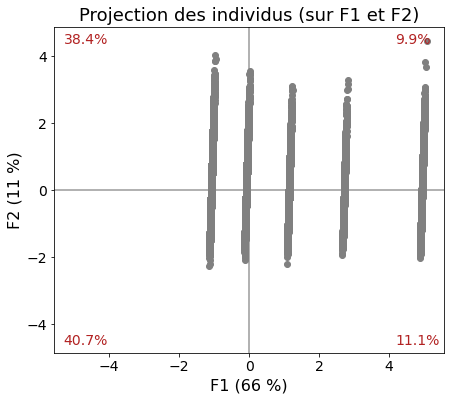

In [7]:
x_y = [0,1]
X_proj = pca.transform(X_olist_fit)

display_factorial_planes(X_proj, x_y, pca, marker="o")

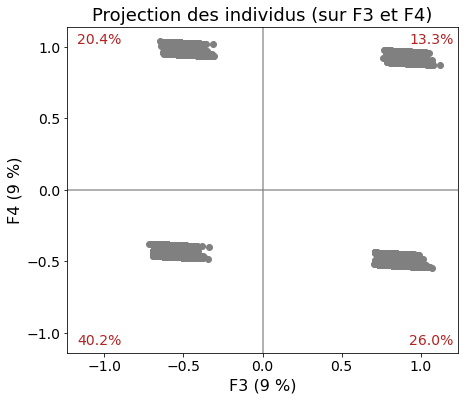

In [8]:
x_y = [2,3]

display_factorial_planes(X_proj, x_y, pca, marker="o")

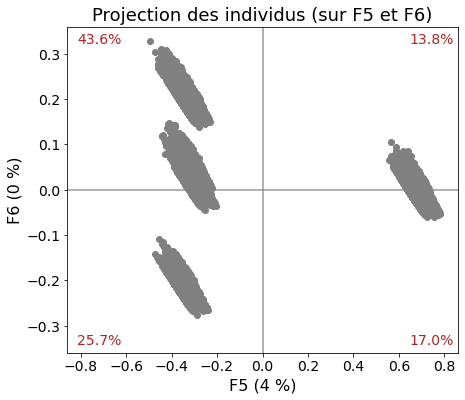

In [9]:
x_y = [4,5]

display_factorial_planes(X_proj, x_y, pca, marker="o")

<a class="anchor" id="section_1_1_2"></a>
### Nettoyage des données

In [10]:
cp_1 = np.where((X_proj[:,0]>4) & (X_proj[:,1]>3.5))
cp_1_list = list(chain.from_iterable(cp_1))

cp_2 =  np.where((X_proj[:,0]>2.6) & (X_proj[:,0]<3) & (X_proj[:,1]>2.6))
cp_2_list = list(chain.from_iterable(cp_2))

cp_3 =  np.where((X_proj[:,0]>1) & (X_proj[:,0]<1.4) & (X_proj[:,1]>2.8))
cp_3_list = list(chain.from_iterable(cp_3))

cp_4 =  np.where((X_proj[:,0]>1) & (X_proj[:,0]<1.4) & (X_proj[:,1]<-2))
cp_4_list = list(chain.from_iterable(cp_4))

cp_5 = np.where((X_proj[:,0]>-0.5) & (X_proj[:,0]<0) & (X_proj[:,1]>3.2))
cp_5_list = list(chain.from_iterable(cp_5))

cp_6 = np.where((X_proj[:,0]>-2) & (X_proj[:,0]<-0.8) & (X_proj[:,1]>3.5))
cp_6_list = list(chain.from_iterable(cp_6))

cp_7 = np.where((X_proj[:,0]>-2) & (X_proj[:,0]<-0.8) & (X_proj[:,1]<-2.0))
cp_7_list = list(chain.from_iterable(cp_7))

liste_ = cp_1_list + cp_2_list + cp_3_list + cp_4_list + cp_5_list + cp_6_list + cp_7_list

result = [] 
for i in liste_: 
    if i not in result: 
        result.append(i) 

indexes_to_keep = set(range(data_olist_raw.shape[0])) - set(result)
data_olist_raw_2 = data_olist_raw.take(list(indexes_to_keep))
display(data_olist_raw_2.shape)
X_proj = []

X_olist_fit_2 = rob_scale.fit_transform(data_olist_raw_2[col_client].values)

display(X_olist_fit_2.shape)

(93323, 42)

(93323, 12)

array([65.55, 11.42,  9.28,  8.7 ,  4.22,  0.38])

array([ 66.,  77.,  86.,  95.,  99., 100.])

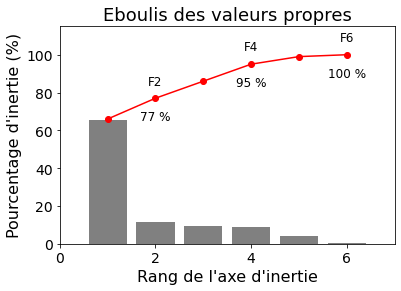

In [11]:
names = data_olist_raw_2[col_client].index
features = col_categ_simple

n_components = 6
pca = PCA(n_components=n_components)
pca.fit(X_olist_fit_2)

pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
display(scree)
scree_cum = scree.cumsum().round()
display(scree_cum)


x_list = range(1, n_components+1)
list(x_list)

plt.figure(figsize=(6,4))

plt.bar(x_list, scree, color="gray")
plt.plot(x_list, scree_cum,c="red",marker='o')

plt.xlabel("Rang de l'axe d'inertie", fontsize=16)
plt.ylabel("Pourcentage d'inertie (%)",fontsize=16)

plt.xticks(np.arange(0,21,2), fontsize=14)
plt.yticks(fontsize=14)

plt.title("Eboulis des valeurs propres", fontsize=18)

plt.xlim(0,7)
plt.ylim(0,115)

for a,b in zip(x_list[1::2], scree_cum[1::2]): 
    plt.text(a, b-10, f"{int(b)} %", fontsize=12, va="center", ha="center", 
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='1'))
    plt.text(a, b+9, f"F{int(a)}",fontsize=12, va="center", ha="center", 
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='1'))

plt.show(block=False)

pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]

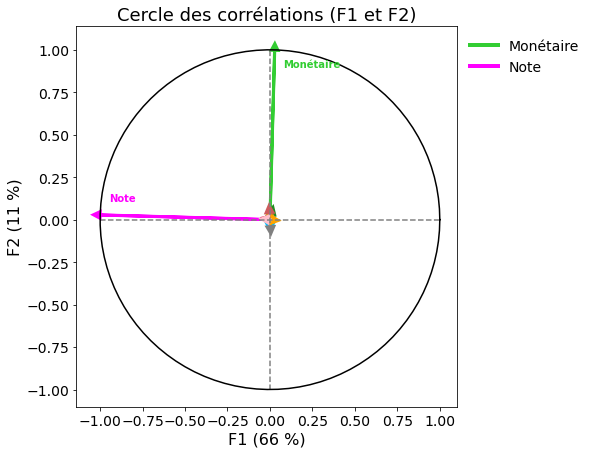

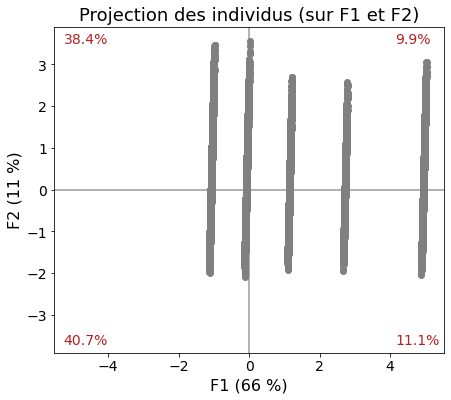

In [12]:
x_y = [0,1]
X_proj = pca.transform(X_olist_fit_2)

correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

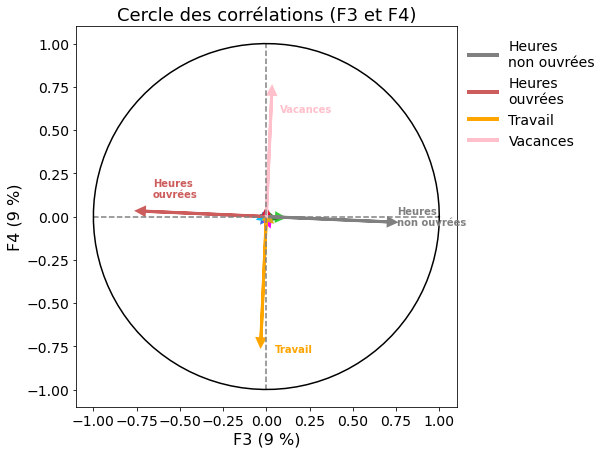

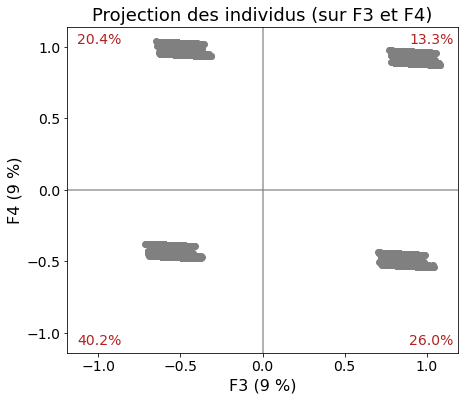

In [13]:
x_y = [2,3]

correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

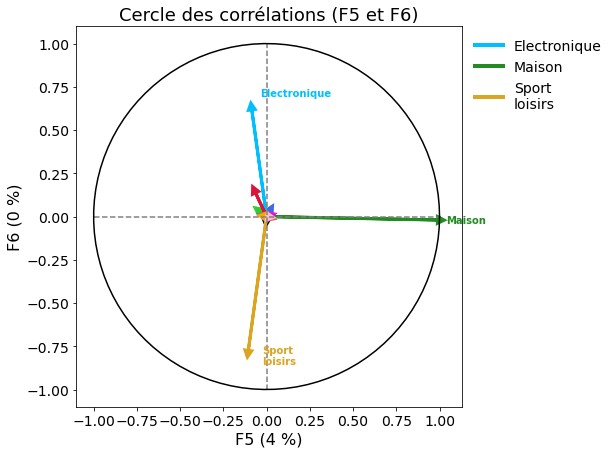

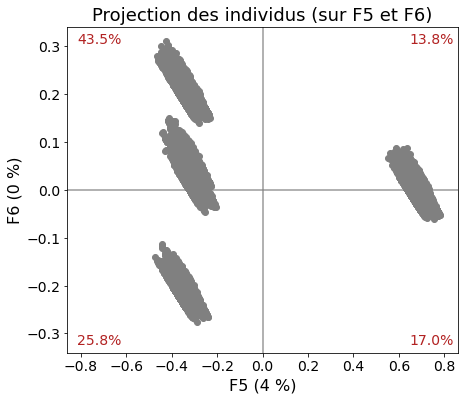

In [14]:
x_y = [4,5]

correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

In [54]:
df_pca = pcs.T

df_pca["impact_var"] = np.abs(df_pca.iloc[:,:]).sum(axis = 1)
df_pca["impact_var"] = df_pca["impact_var"]*100/(df_pca["impact_var"].sum(axis = 0))
df_pca = df_pca.sort_values("impact_var", ascending=False)

df_best_pca = df_pca.iloc[:15,:]
df_best_pca.shape

(12, 7)

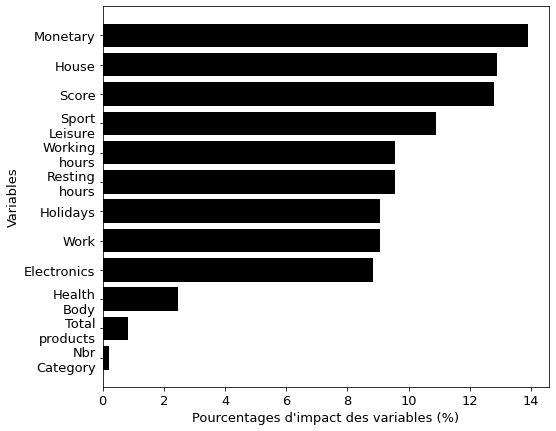

In [55]:
df_best_pca = df_best_pca.sort_values("impact_var", ascending=True)

plt.figure(figsize=(8,7))

plt.barh(width = df_best_pca.iloc[:,-1], y = df_best_pca.index, color="black")

plt.xlabel("Pourcentages d'impact des variables (%)", fontsize = 13)
plt.ylabel("Variables", fontsize = 13)

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

In [18]:
data_olist_pca = data_olist_raw_2.sort_values("order_purchase_timestamp", ascending=True).reset_index(drop=True)

In [19]:
data_olist_pca["order_purchase_timestamp"] = pd.to_datetime(data_olist_pca["order_purchase_timestamp"])
display(data_olist_pca.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93323 entries, 0 to 93322
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_unique_id            93323 non-null  object        
 1   order_purchase_timestamp      93323 non-null  datetime64[ns]
 2   recency                       93323 non-null  float64       
 3   frequency                     93323 non-null  float64       
 4   monetary                      93323 non-null  float64       
 5   total_products                93323 non-null  float64       
 6   nbr_category                  93323 non-null  float64       
 7   nbr_payment                   93323 non-null  float64       
 8   payment_installments          93323 non-null  float64       
 9   heure                         93323 non-null  float64       
 10  jour_semaine                  93323 non-null  float64       
 11  jour                        

None

In [22]:
X_olist_categ = data_olist_pca[col_client].values

rob_scale = preprocessing.RobustScaler()

X_olist_fit = rob_scale.fit_transform(X_olist_categ)

In [23]:
display(X_olist_fit.shape)

(93323, 12)

<a class="anchor" id="section_1_2"></a>
## K-means sur le jeu de données

Nous allons effectuer une segmentation sur les données. 

Dans un premier temps, nous allons déterminer différents scores (méthode du coude, score Davies-Bouldin, score Silhouette et score Calinski) pour chaque nombre de clusters choisis (entre 2 et 30). Nous représenterons l'ensemble des scores obtenus puis nous choisirons les nombres de centroïdes ayant obtenus les meilleurs scores. 

Dans un second temps, nous allons utiliser la méthode de classification hiérarchique ascendante pour 100 clusters afin d'établir le nombre de cluster idéal.

Dans un troisième temps, nous allons représenter les segmentations choisies. 

Enfin, nous allons représenter chaque client selon un radar et déterminer si des clients-types émergent ou non. 

In [32]:
inertia_olist_new_feat = []
silhouettes_olist_new_feat = []
davies_olist_new_feat = []
calinski_olist_new_feat = []
K_range_olist_new_feat = range(2, 31)

for k in K_range_olist_new_feat:
    model = KMeans(n_clusters = k, init = "k-means++", random_state = 0).fit(X_olist_fit)
    inertia_olist_new_feat.append(model.inertia_)
    
    silh = metrics.silhouette_score(X_olist_fit,model.labels_)
    silhouettes_olist_new_feat.append(silh)
    
    dav = metrics.davies_bouldin_score(X_olist_fit,model.labels_)
    davies_olist_new_feat.append(dav)
    
    cali = metrics.calinski_harabasz_score(X_olist_fit,model.labels_)
    calinski_olist_new_feat.append(cali)
    
    if (k==5) | (k==15) | (k==25):
        print(k, round(silh,5), round(dav,5), round(cali,0))
    else:
        continue

5 0.30282 1.19402 63979.0
15 0.29594 1.2928 39469.0
25 0.35136 1.09891 34866.0


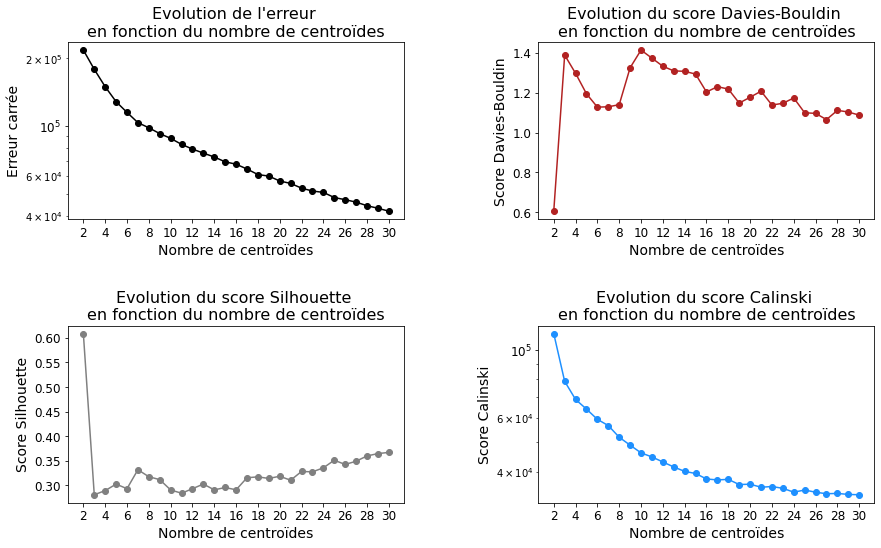

In [33]:
plt.figure(figsize = (14,8))

plt.subplot(221)
plt.plot(K_range_olist_new_feat, inertia_olist_new_feat, marker = 'o', color = "black")

plt.xticks(K_range_olist_new_feat[::2], fontsize = 12)
plt.yticks(fontsize = 12)

plt.yscale("log")

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Erreur carrée", fontsize = 14)

plt.title("Evolution de l'erreur \nen fonction du nombre de centroïdes", fontsize = 16)


plt.subplot(222)

plt.plot(K_range_olist_new_feat, davies_olist_new_feat, marker = 'o', color="firebrick")

plt.xticks(K_range_olist_new_feat[::2], fontsize = 12)
plt.yticks(fontsize = 12)

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Score Davies-Bouldin", fontsize = 14)

plt.title("Evolution du score Davies-Bouldin \nen fonction du nombre de centroïdes", fontsize = 16)

plt.subplot(223)

plt.plot(K_range_olist_new_feat, silhouettes_olist_new_feat, marker = 'o', color="gray")

plt.xticks(K_range_olist_new_feat[::2], fontsize = 12)
plt.yticks(fontsize = 12)

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Score Silhouette", fontsize = 14)

plt.title("Evolution du score Silhouette \nen fonction du nombre de centroïdes", fontsize = 16)

plt.subplot(224)

plt.plot(K_range_olist_new_feat, calinski_olist_new_feat, marker = 'o', color="dodgerblue")

plt.yscale("log")

plt.xticks(K_range_olist_new_feat[::2], fontsize = 12)
plt.yticks(fontsize = 12)

plt.xlabel("Nombre de centroïdes", fontsize = 14)
plt.ylabel("Score Calinski", fontsize = 14)

plt.title("Evolution du score Calinski \nen fonction du nombre de centroïdes", fontsize = 16)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.4, 
                    hspace = 0.6)
plt.show()

<a class="anchor" id="section_1_3"></a>
## Classification ascendante hierarchique

En nous basant sur le k-means, nous allons créer 100 clusters qui seront utilisés pour la classification ascendante hierarchique (CAH). Le fait de créer 100 clusters permet une meilleure visualisation de la classification mais aussi d'éviter les problèmes de mémoire.

In [83]:
model_new_feat_100 = KMeans(n_clusters = 100, init = "k-means++", random_state = 0)
model_new_feat_100.fit(X_olist_fit)

data_cluster_new_feat = model_new_feat_100.cluster_centers_

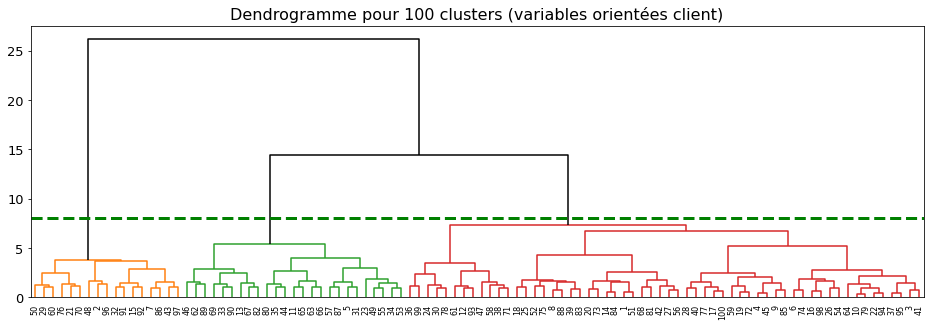

In [85]:
linkage_data_new_feat = linkage(data_cluster_new_feat, method = 'ward', metric = 'euclidean')
labels_str = [str(i) for i in np.arange(1,101,1)]

plt.figure(figsize = (16, 5))

dendrogram(linkage_data_new_feat, labels = labels_str, orientation = "top", 
           color_threshold = 8, above_threshold_color = 'black')

plt.axhline(y = 8, ls="dashed", linewidth=3, c = "green")

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 13)

plt.title("Dendrogramme pour 100 clusters (variables orientées client)", fontsize = 16)

plt.show()

<a class="anchor" id="section_1_4"></a>
## Visualisation de la segmentation

En nous basant sur les scores plus haut, nous choisissons de représenter les données selon 3 clusters, 6 clusters et 7 clusters.

Nous allons visualiser la segmentation en représentant les variables deux à deux et après avoir fait un t-SNE. 

In [27]:
model_new_feat_3 = KMeans(n_clusters = 3, init = "k-means++", random_state = 0)
model_new_feat_3.fit(X_olist_fit)

model_new_feat_6 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_new_feat_6.fit(X_olist_fit)

model_new_feat_7 = KMeans(n_clusters = 7, init = "k-means++", random_state = 0)
model_new_feat_7.fit(X_olist_fit)

KMeans(n_clusters=7, random_state=0)

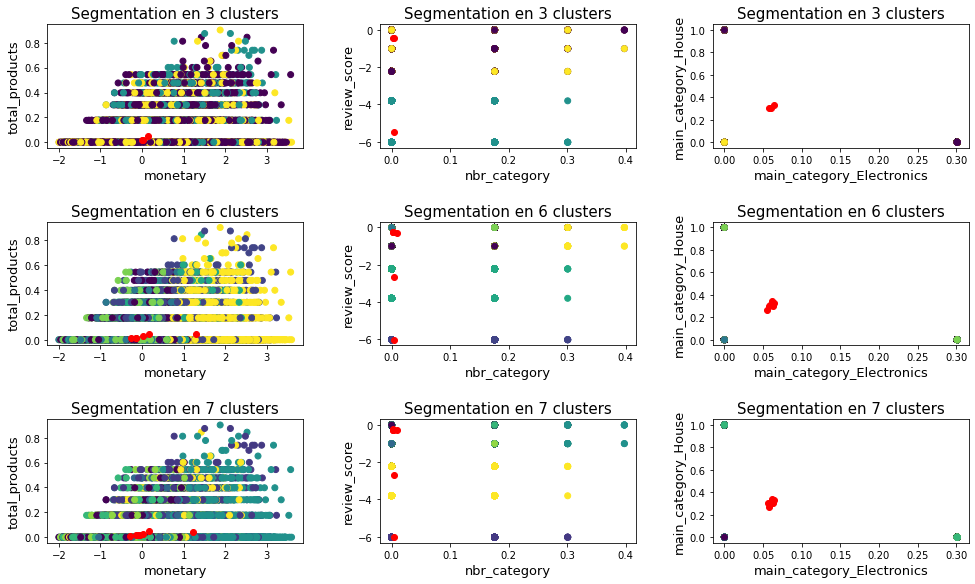

In [42]:
plt.figure(figsize=(16,9))

k = 0
for i in range (0,6,2):
    k += 1
    plt.subplot(3,3,k)
    plt.scatter(X_olist_fit[:,i], X_olist_fit[:,i+1], c=model_new_feat_3.predict(X_olist_fit))
    plt.scatter(model_new_feat_3.cluster_centers_[:,i], model_new_feat_3.cluster_centers_[:,i+1], color = "red")
    plt.xlabel(f"{col_categ[i]}", fontsize = 13)
    plt.ylabel(f"{col_categ[i+1]}", fontsize = 13)
    plt.title(f"Segmentation en 3 clusters", fontsize = 15)

for i in range (0,6,2):
    k += 1
    plt.subplot(3,3,k)
    plt.scatter(X_olist_fit[:,i], X_olist_fit[:,i+1], c=model_new_feat_6.predict(X_olist_fit))
    plt.scatter(model_new_feat_6.cluster_centers_[:,i], model_new_feat_6.cluster_centers_[:,i+1], color = "red")
    plt.xlabel(f"{col_categ[i]}", fontsize = 13)
    plt.ylabel(f"{col_categ[i+1]}", fontsize = 13)
    plt.title(f"Segmentation en 6 clusters", fontsize = 15)
    
    
for i in range (0,6,2):
    k += 1
    plt.subplot(3,3,k)
    plt.scatter(X_olist_fit[:,i], X_olist_fit[:,i+1], c=model_new_feat_7.predict(X_olist_fit))
    plt.scatter(model_new_feat_7.cluster_centers_[:,i], model_new_feat_7.cluster_centers_[:,i+1], color = "red")
    plt.xlabel(f"{col_categ[i]}", fontsize = 13)
    plt.ylabel(f"{col_categ[i+1]}", fontsize = 13)
    plt.title(f"Segmentation en 7 clusters", fontsize = 15)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.3, 
                    hspace = 0.6)
plt.show()

In [25]:
tsne = manifold.TSNE(n_components=2, perplexity=60, learning_rate="auto", init="pca", random_state = 0)

X_tsne = tsne.fit_transform(X_olist_fit)

C:\Users\farid\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


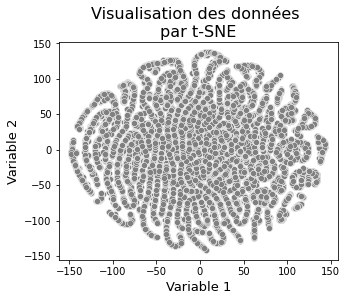

In [26]:
plt.figure(figsize=(5,4))
sns.scatterplot(x = X_tsne[:,0], y = X_tsne[:,1], color="gray")

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données \npar t-SNE", fontsize=16)

plt.show()

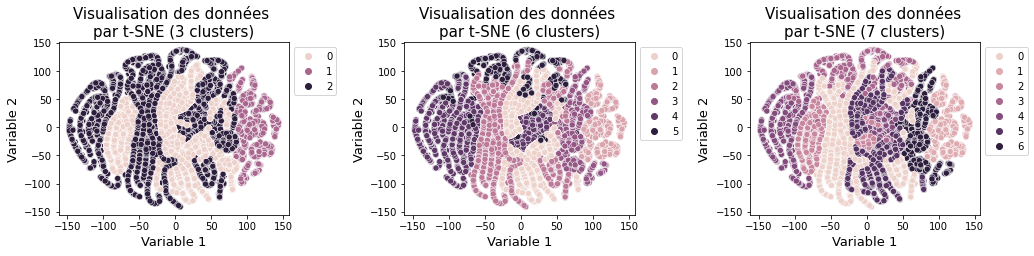

In [28]:
plt.figure(figsize=(16,3))
plt.subplot(131)
sns.scatterplot(x = X_tsne[:,0], 
                y = X_tsne[:,1],
                hue = model_new_feat_3.predict(X_olist_fit),
                legend = 'full')

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données \npar t-SNE (3 clusters)", fontsize=15)

plt.legend(bbox_to_anchor=(1,1))

plt.subplot(132)
sns.scatterplot(x = X_tsne[:,0], 
                y = X_tsne[:,1],
                hue = model_new_feat_6.predict(X_olist_fit),
                legend = 'full')

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données \npar t-SNE (6 clusters)", fontsize=15)

plt.legend(bbox_to_anchor=(1,1))

plt.subplot(133)
sns.scatterplot(x = X_tsne[:,0], 
                y = X_tsne[:,1],
                hue = model_new_feat_7.predict(X_olist_fit),
                legend = 'full')

plt.xlabel("Variable 1", fontsize = 13)
plt.ylabel("Variable 2", fontsize = 13)

plt.title("Visualisation des données \npar t-SNE (7 clusters)", fontsize=15)

plt.legend(bbox_to_anchor=(1,1))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)
plt.show()

Avec les 2 visualisations montrées plus haut, nous voyons qu'il n'y a pas de segmentation visuelle. 

<a class="anchor" id="section_1_5"></a>
## Représentation des clients types

Maintenant que nous venons de sélectionner les clusters les plus pertinents, nous allons représenter chaque client type sur un radar, ce qui permettra de faire ressortir les points forts et les points faibles des clients et de les identifier.

<a class="anchor" id="section_1_5_1"></a>
### Préparation des radars

Nous commencons par associer chaque client au label qui lui est propre pour chaque segmentation. Ensuite, nous créeons 3 dataframes pour chaque segmentation et nous groupons (en faisant la moyenne) les données pour chaque segmentation selon chaque label. Enfin nous appliquons une normalisation entre 0 et 10 de telle sorte à déterminer les forces et faiblesses des clients. 

In [29]:
data_olist_pca["cluster_3"] = pd.Series(model_new_feat_3.labels_)
data_olist_pca["cluster_6"] = pd.Series(model_new_feat_6.labels_)
data_olist_pca["cluster_7"] = pd.Series(model_new_feat_7.labels_)

pourcentage_3 = ((data_olist_pca["cluster_3"].value_counts(normalize=True).sort_index())*100).round(1)

pourcentage_6 = ((data_olist_pca["cluster_6"].value_counts(normalize=True).sort_index())*100).round(1)

pourcentage_7 = ((data_olist_pca["cluster_7"].value_counts(normalize=True).sort_index())*100).round(1)

In [30]:
col_categ_3 = ['monetary', 'total_products', 'nbr_category',
               'main_category_Electronics', 'main_category_House', 'main_category_Sport_leisure',"main_category_Health_body",
               'heure_commande_Resting_hours', 'heure_commande_Working_hours',
               'holidays_No', 'holidays_Yes', 
               'review_score',   
               "cluster_3"]

col_categ_6 = ['monetary', 'total_products', 'nbr_category',
               'main_category_Electronics', 'main_category_House', 'main_category_Sport_leisure',"main_category_Health_body",
               'heure_commande_Resting_hours', 'heure_commande_Working_hours',
               'holidays_No', 'holidays_Yes', 
               'review_score',   
               "cluster_6"]

col_categ_7 = ['monetary', 'total_products', 'nbr_category',
                'main_category_Electronics', 'main_category_House', 'main_category_Sport_leisure',"main_category_Health_body",
                'heure_commande_Resting_hours', 'heure_commande_Working_hours',
                'holidays_No', 'holidays_Yes', 
                'review_score', 
                "cluster_7"
                ]

col_simple = ['Monétaire', "Nbr\nd'articles", "Nbr\ncatégorie", 
              'Electronique', 'Maison', 'Sport\nloisirs', "Santé\nCorps",
              'Heures\nnon ouvrées', 'Heures\nouvrées', 
              'Travail', 'Vacances', 
              "Note"]


In [31]:
cluster_client_3 = data_olist_pca[col_categ_3].groupby("cluster_3").mean()
cluster_client_6 = data_olist_pca[col_categ_6].groupby("cluster_6").mean()
cluster_client_7 = data_olist_pca[col_categ_7].groupby("cluster_7").mean()

In [32]:
scaler = MinMaxScaler(feature_range=(0, 10))

cluster_3 = pd.DataFrame(scaler.fit_transform(cluster_client_3), 
                         columns = cluster_client_3.columns)

cluster_6 = pd.DataFrame(scaler.fit_transform(cluster_client_6), 
                         columns = cluster_client_6.columns)

cluster_7 = pd.DataFrame(scaler.fit_transform(cluster_client_7), 
                         columns = cluster_client_7.columns)

<a class="anchor" id="section_1_5_2"></a>
### 1<sup>ère</sup> segmentation

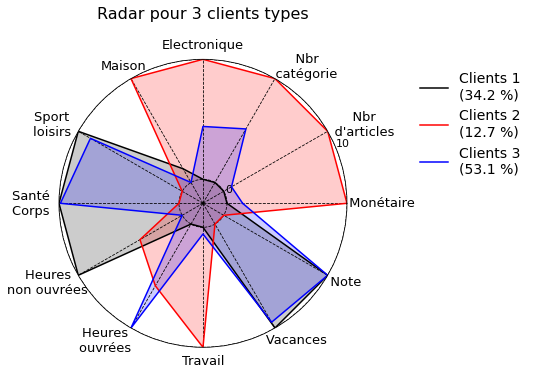

In [155]:
categories = ['          Monétaire', "            Nbr\n            d'articles", "            Nbr\n            catégorie", 
              'Electronique', 'Maison', 'Sport       \nloisirs       ', "Santé       \nCorps       ",
              'Heures         \nnon ouvrées         ', 'Heures         \nouvrées         ', 
              'Travail', '       Vacances', 
              "   Note"]

client_1 = cluster_3.iloc[0,:].values.tolist()
client_2 = cluster_3.iloc[1,:].values.tolist()
client_3 = cluster_3.iloc[2,:].values.tolist()

client_1.append(client_1[0])
client_2.append(client_2[0])
client_3.append(client_3[0])


liste_client = [client_1, client_2, client_3]
colors = ["black", "red", "blue", "green"]

label_loc = np.linspace(start = 0, stop = 2 * np.pi, num=len(client_1))
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(5, 5))
plt.subplot(polar=True)

plt.plot(label_loc, client_1, label = f"Clients 1 \n({pourcentage_3[0]} %)", color = "black")
plt.fill(angles, client_1, "black", alpha=0.2)

plt.plot(label_loc, client_2, label = f"Clients 2 \n({pourcentage_3[1]} %)", color = "red")
plt.fill(angles, client_2, "red", alpha=0.2)

plt.plot(label_loc, client_3, label = f"Clients 3 \n({pourcentage_3[2]} %)", color = "blue")
plt.fill(angles, client_3, "blue", alpha=0.2)
    
    
lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)
plt.grid(visible=True, color="black", linestyle="dashed")
    
plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("Radar pour 3 clients types", size=16, pad=20)
plt.legend(bbox_to_anchor=(1.21, 1),frameon=False, fontsize = 14)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.6, 
                    hspace = 0.4)
plt.show()

Avec le radar, nous pouvons identifier 3 clients :
- Client 1 (**client faisant des achats de compléments pour les vacances/fêtes de Noël**) : 
    - client satisfait, très peu dépensier, achetant exclusivement des articles sport/loisirs et de soin/beauté, durant la soirée et en vacances.
    
- Client 2 (**acheteurs/opportunistes aisés insatisfait**) : 
    - client insatisfait, achetant en grande quantité, des articles d'électronique et de maison, en période scolaire à toute heure.

- Client 3 (**clients dépensant pour les fêtes et/ou la rentrée scolaire**) : 
    - client satisfait, peu dépensier, achetant de tout sauf des produits de maisons, exclusivement la journée et pendant les vacances.
    
Cette segmentation permet de décrire 3 clients. Cependant, la proportion de client 3 semble très forte. Nous allons regarder les 2 autres segmentations et voir si elles sont plus satisfaisantes ou non.

<a class="anchor" id="section_1_5_3"></a>
### 2<sup>ème</sup> segmentation

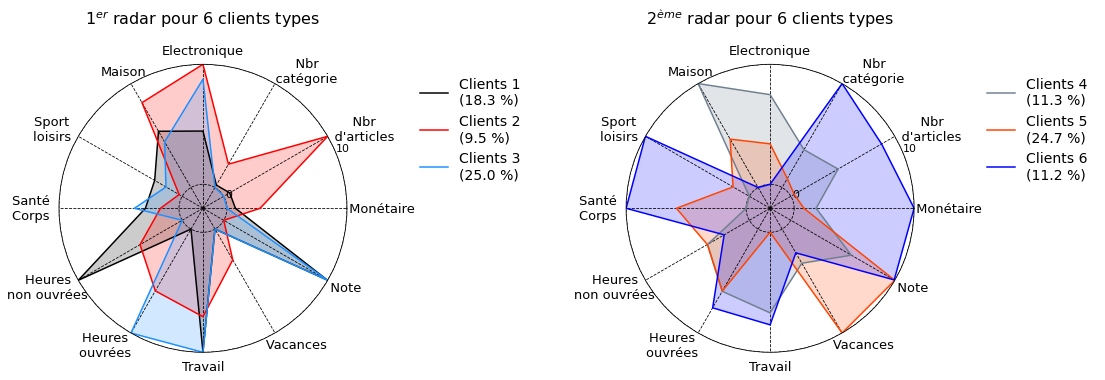

In [157]:
client_1 = cluster_6.iloc[0,:].values.tolist()
client_2 = cluster_6.iloc[1,:].values.tolist()
client_3 = cluster_6.iloc[2,:].values.tolist()
client_4 = cluster_6.iloc[3,:].values.tolist()
client_5 = cluster_6.iloc[4,:].values.tolist()
client_6 = cluster_6.iloc[5,:].values.tolist()


client_1.append(client_1[0])
client_2.append(client_2[0])
client_3.append(client_3[0])
client_4.append(client_4[0])
client_5.append(client_5[0])
client_6.append(client_6[0])


label_loc = np.linspace(start = 0, stop = 2 * np.pi, num=len(client_1))

plt.figure(figsize=(16, 5))
plt.subplot(121, polar=True)


plt.plot(label_loc, client_1, label = f"Clients 1 \n({pourcentage_6[0]} %)", color="black")
plt.fill(angles, client_1, 'black', alpha=0.2)

plt.plot(label_loc, client_2, label = f"Clients 2 \n({pourcentage_6[1]} %)", color="red")
plt.fill(angles, client_2, "red",alpha=0.2)

plt.plot(label_loc, client_3, label = f"Clients 3 \n({pourcentage_6[2]} %)", color="dodgerblue")
plt.fill(angles, client_3, "dodgerblue",alpha=0.2)


lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)


plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("$1^{er}$ radar pour 6 clients types", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.21, 1),frameon=False, fontsize = 14)

plt.subplot(122, polar=True)


plt.plot(label_loc, client_4, label = f"Clients 4 \n({pourcentage_6[3]} %)", color="slategray")
plt.fill(angles, client_4, 'slategray', alpha=0.2)

plt.plot(label_loc, client_5, label = f"Clients 5 \n({pourcentage_6[4]} %)", color="orangered")
plt.fill(angles, client_5, "orangered",alpha=0.2)

plt.plot(label_loc, client_6, label = f"Clients 6 \n({pourcentage_6[5]} %)", color="blue")
plt.fill(angles, client_6, "blue",alpha=0.2)



lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)

plt.grid(visible=True, color="black", linestyle="dashed")

plt.xticks(fontsize = 13)
plt.yticks([0,10], fontsize = 11)
    
plt.ylim(-2,10)
    
plt.title("$2^{ème}$ radar pour 6 clients types", size=16, pad=20)

plt.legend(bbox_to_anchor=(1.21, 1),frameon=False, fontsize = 14)

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.6, 
                    hspace = 0.4)

plt.show()

- Client 1 (**opportuniste satisfait**): 
    - client satisfait, peu dépensier, achetant de tout en soirée, pendant la période scolaire.
- Client 2 (**acheteurs/opportunistes insatisfaits**): 
    - client mécontent, achetant beaucoup d'articles d'électronique et de maisons en grande quantité peu importe la période de l'année.
- Client 3 (**opportuniste orienté électronique**): 
    - client satisfait, achetant en petite quantité, majoritairement des articles d'électronique, en journée
- Client 4 (**client orienté article maison et électronique**) : 
    - client plutôt satisfait, achetant des produits pour la maison et d'électronique, à n'importe quel moment de la journée et de l'année
- Client 5 (**clients rentrée/Noël**): 
    - client satisfait, achetant de tout, à n'importe quel moment de la journée pendant les vacances
- Client 6 (**couple/parents aisés**): 
    - client satisfait, achetant des produits pour la maison et de bien-être, en journée principalement et pendant la période scolaire

    
Avec une segmentation en 6 clusters, nous arrivons à identifier plusieurs types de clients. Nous allons continuer avec la segementation en 7.

<a class="anchor" id="section_1_5_4"></a>
### 3<sup>ème</sup> segmentation

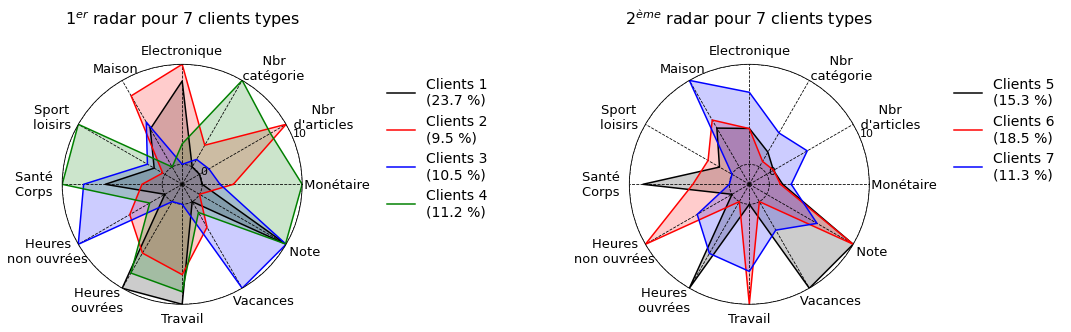

In [158]:
client_1 = cluster_7.iloc[0,:].values.tolist()
client_2 = cluster_7.iloc[1,:].values.tolist()
client_3 = cluster_7.iloc[2,:].values.tolist()
client_4 = cluster_7.iloc[3,:].values.tolist()
client_5 = cluster_7.iloc[4,:].values.tolist()
client_6 = cluster_7.iloc[5,:].values.tolist()
client_7 = cluster_7.iloc[6,:].values.tolist()


client_1.append(client_1[0])
client_2.append(client_2[0])
client_3.append(client_3[0])
client_4.append(client_4[0])
client_5.append(client_5[0])
client_6.append(client_6[0])
client_7.append(client_7[0])


liste_client = []
liste_client = [client_1, client_2, client_3, client_4, client_5, client_6, client_7]

liste_color = ["black", "red", "blue", "green", "black", "red", "blue", "green", "black", "red", "blue", "green"]

label_loc = np.linspace(start = 0, stop = 2 * np.pi, num=len(client_1))

plt.figure(figsize=(16, 10))

k = 0
for i in range (0,8,4):
    k += 1
    plt.subplot(2,2,k, polar=True)
    plt.plot(label_loc, liste_client[i], label = f"Clients {i+1} \n({pourcentage_7[i]} %)", color = liste_color[i])
    plt.fill(angles, liste_client[i], liste_color[i], alpha=0.2)
    
    plt.plot(label_loc, liste_client[i+1], label = f"Clients {i+2} \n({pourcentage_7[i+1]} %)", color = liste_color[i+1])
    plt.fill(angles, liste_client[i+1], liste_color[i+1], alpha=0.2)
    
    plt.plot(label_loc, liste_client[i+2], label = f"Clients {i+3} \n({pourcentage_7[i+2]} %)", color = liste_color[i+2])
    plt.fill(angles, liste_client[i+2], liste_color[i+2], alpha=0.2)
    
    if (i+3)<7:
        plt.plot(label_loc, liste_client[i+3], label = f"Clients {i+4} \n({pourcentage_7[i+3]} %)", color = liste_color[i+3])
        plt.fill(angles, liste_client[i+3], liste_color[i+3], alpha=0.2)    
    
    lines, labels = plt.thetagrids(np.arange(0, 360, (360/len(categories))), categories)
    plt.grid(visible=True, color="black", linestyle="dashed")
    
    plt.xticks(fontsize = 13)
    plt.yticks([0,10], fontsize = 11)
    plt.ylim(-2,10)
    if k==1:
        plt.title("$1^{er}$ radar pour 7 clients types", size=16, pad=20)
    else:
        plt.title("$2^{ème}$ radar pour 7 clients types", size=16, pad=20)

    plt.legend(bbox_to_anchor=(1.3, 1),frameon=False, fontsize = 14)


plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.6, 
                    hspace = 0.4)

plt.show()

- Client 1 (**opportuniste orienté électronique**): 
    - client satisfait, achetant en petite quantité, majoritairement des articles d'électronique, en journée
- Client 2 (**acheteurs/opportunistes insatisfaits**): 
    - client mécontent, achetant beaucoup d'articles d'électronique et de maisons en grande quantité peu importe la période de l'année.
- Client 3 (**vacancier faisant des achats de complément**): 
    - client satisfait, peu dépensier, achetant des produits de soin/beauté en soirée, pendant les vacances.
- Client 4 (**couple/parents aisés**): 
    - client satisfait, achetant des produits pour la maison et de bien-être, en journée principalement et pendant la période scolaire
- Client 5 (**clients rentrée/Noël**): 
    - client satisfait, achetant de tout, en journée pendant les vacances
- Client 6 (**opportuniste satisfait**): 
    - client satisfait, peu dépensier, achetant de tout en soirée, pendant la période scolaire.
- Client 7 (**client orienté article maison et électronique**) : 
    - client satisfait, dépensant peu d'argent, achetant peu d'articles, de tout
    
Avec une segmentation en 7 clusters, nous arrivons à identifier plusieurs types de clients. En revanche, les clients 3 et 5 sont une décomposition du client 5. 

La segmentation qui paraît le plus logique est la segmentation en 6 clusters car les clients sont plus facilement identifiable.

<a class="anchor" id="chapter2"></a>
# Maintenance
<a class="anchor" id="section_2_1"></a>
## Préparation des données

Nous venons d'établir une segmentation avec l'ensemble des données. Nous allons étudier la stabilité de la segmentation en comparant la segmentation sur 
- l'ensemble de la période (24 mois) et en reculant dans le temps (24 mois - X mois),
- deux mois consécutifs et 
- en nous fixant à un instant t donné (par exemple après 1 an) et comparé chaque segmentation à t = 1 an et t = 1 an + X mois.

Pour cela, nous allons utiliser le score Rand ajusté (ARI) où les labels attribués à chaque client sont comparés.

Cette comparaison sera faite sur le fichier de données sur lequel nous allons extraire les clients ayant fait des commandes pendant une période inférieur à 24 mois. 

Nous ferons de même sur un fichier créee dans le premier notebook. Dans ce fichier-là, nous n'avons pas groupé selon les clients. Le groupement sera fait après avoir isolé les données sur une plage temporelle souhaité (24 mois - X mois). Comme la fréquence d'achat d'un client est majoritairement de 1, les scores ARI seront en théorie similaire. Dans un cas où la fréquence serait bien plus disperse, le score ARI serait sujet à de plus grandes variations.

In [62]:
data_pca = {}
liste_mois = ["1_mois", "2_mois", "3_mois", "4_mois", "5_mois", "6_mois", "7_mois", "8_mois","9_mois","10_mois",
              "11_mois", "12_mois", "13_mois", "14_mois","15_mois","16_mois", "17_mois", "18_mois", "19_mois"]

last_day_maintenance = (data_olist_pca["order_purchase_timestamp"].max() + datetime.timedelta(days=1)).replace(hour=0, 
                                                                                                               minute=0,
                                                                                                               second = 0)
display((last_day_maintenance))

for i in range (0,19,1):
    data_pca[liste_mois[i]] = data_olist_pca
    mois = last_day_maintenance - datetime.timedelta(days=30*(i+1))
    data_pca[liste_mois[i]] = data_pca[liste_mois[i]].loc[data_pca[liste_mois[i]]["order_purchase_timestamp"]<mois,:]
    data_pca[liste_mois[i]] = data_pca[liste_mois[i]].reset_index(drop=True)

Timestamp('2018-08-30 00:00:00')

In [64]:
X_1_0 = rob_scale.fit_transform(data_olist_pca[col_client].values)
X_1_1 = rob_scale.fit_transform(data_pca['1_mois'][col_client].values)
X_1_2 = rob_scale.fit_transform(data_pca['2_mois'][col_client].values)
X_1_3 = rob_scale.fit_transform(data_pca['3_mois'][col_client].values)
X_1_4 = rob_scale.fit_transform(data_pca['4_mois'][col_client].values)
X_1_5 = rob_scale.fit_transform(data_pca['5_mois'][col_client].values)
X_1_6 = rob_scale.fit_transform(data_pca['6_mois'][col_client].values)
X_1_7 = rob_scale.fit_transform(data_pca['7_mois'][col_client].values)
X_1_8 = rob_scale.fit_transform(data_pca['8_mois'][col_client].values)
X_1_9 = rob_scale.fit_transform(data_pca['9_mois'][col_client].values)
X_1_10 = rob_scale.fit_transform(data_pca['10_mois'][col_client].values)
X_1_11 = rob_scale.fit_transform(data_pca['11_mois'][col_client].values)
X_1_12 = rob_scale.fit_transform(data_pca['12_mois'][col_client].values)
X_1_13 = rob_scale.fit_transform(data_pca['13_mois'][col_client].values)
X_1_14 = rob_scale.fit_transform(data_pca['14_mois'][col_client].values)
X_1_15 = rob_scale.fit_transform(data_pca['15_mois'][col_client].values)
X_1_16 = rob_scale.fit_transform(data_pca['16_mois'][col_client].values)
X_1_17 = rob_scale.fit_transform(data_pca['17_mois'][col_client].values)
X_1_18 = rob_scale.fit_transform(data_pca['18_mois'][col_client].values)
X_1_19 = rob_scale.fit_transform(data_pca['19_mois'][col_client].values)

In [65]:
model_6_1 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_1.fit(X_1_1)

model_6_2 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_2.fit(X_1_2)

model_6_3 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_3.fit(X_1_3)

model_6_4 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_4.fit(X_1_4)

model_6_5 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_5.fit(X_1_5)

model_6_6 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_6.fit(X_1_6)

model_6_7 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_7.fit(X_1_7)

model_6_8 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_8.fit(X_1_8)

model_6_9 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_9.fit(X_1_9)

model_6_10 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_10.fit(X_1_10)

model_6_11 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_11.fit(X_1_11)

model_6_12 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_12.fit(X_1_12)

model_6_13 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_13.fit(X_1_13)

model_6_14 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_14.fit(X_1_14)

model_6_15 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_15.fit(X_1_15)

model_6_16 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_16.fit(X_1_16)

model_6_17 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_17.fit(X_1_17)

model_6_18 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_18.fit(X_1_18)

model_6_19 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_19.fit(X_1_19)

KMeans(n_clusters=6, random_state=0)

In [66]:
data_pca['1_mois']["cluster_6_1"] = pd.Series(model_6_1.labels_)
data_pca['2_mois']["cluster_6_2"] = pd.Series(model_6_2.labels_)
data_pca['3_mois']["cluster_6_3"] = pd.Series(model_6_3.labels_)
data_pca['4_mois']["cluster_6_4"] = pd.Series(model_6_4.labels_)
data_pca['5_mois']["cluster_6_5"] = pd.Series(model_6_5.labels_)
data_pca['6_mois']["cluster_6_6"] = pd.Series(model_6_6.labels_)
data_pca['7_mois']["cluster_6_7"] = pd.Series(model_6_7.labels_)
data_pca['8_mois']["cluster_6_8"] = pd.Series(model_6_8.labels_)
data_pca['9_mois']["cluster_6_9"] = pd.Series(model_6_9.labels_)
data_pca['10_mois']["cluster_6_10"] = pd.Series(model_6_10.labels_)
data_pca['11_mois']["cluster_6_11"] = pd.Series(model_6_11.labels_)
data_pca['12_mois']["cluster_6_12"] = pd.Series(model_6_12.labels_)
data_pca['13_mois']["cluster_6_13"] = pd.Series(model_6_13.labels_)
data_pca['14_mois']["cluster_6_14"] = pd.Series(model_6_14.labels_)
data_pca['15_mois']["cluster_6_15"] = pd.Series(model_6_15.labels_)
data_pca['16_mois']["cluster_6_16"] = pd.Series(model_6_16.labels_)
data_pca['17_mois']["cluster_6_17"] = pd.Series(model_6_17.labels_)
data_pca['18_mois']["cluster_6_18"] = pd.Series(model_6_18.labels_)
data_pca['19_mois']["cluster_6_19"] = pd.Series(model_6_19.labels_)

In [67]:
liste_dataframe_1_6 = [data_olist_pca[["customer_unique_id", "cluster_6"]],
                       data_pca['1_mois'][["customer_unique_id", "cluster_6_1"]],
                       data_pca['2_mois'][["customer_unique_id", "cluster_6_2"]],
                       data_pca['3_mois'][["customer_unique_id", "cluster_6_3"]],
                       data_pca['4_mois'][["customer_unique_id", "cluster_6_4"]],
                       data_pca['5_mois'][["customer_unique_id", "cluster_6_5"]],
                       data_pca['6_mois'][["customer_unique_id", "cluster_6_6"]],
                       data_pca['7_mois'][["customer_unique_id", "cluster_6_7"]],
                       data_pca['8_mois'][["customer_unique_id", "cluster_6_8"]],
                       data_pca['9_mois'][["customer_unique_id", "cluster_6_9"]],
                       data_pca['10_mois'][["customer_unique_id", "cluster_6_10"]],
                       data_pca['11_mois'][["customer_unique_id", "cluster_6_11"]],
                       data_pca['12_mois'][["customer_unique_id", "cluster_6_12"]],
                       data_pca['13_mois'][["customer_unique_id", "cluster_6_13"]],
                       data_pca['14_mois'][["customer_unique_id", "cluster_6_14"]],
                       data_pca['15_mois'][["customer_unique_id", "cluster_6_15"]],
                       data_pca['16_mois'][["customer_unique_id", "cluster_6_16"]],
                       data_pca['17_mois'][["customer_unique_id", "cluster_6_17"]],
                       data_pca['18_mois'][["customer_unique_id", "cluster_6_18"]],
                       data_pca['19_mois'][["customer_unique_id", "cluster_6_19"]]
                    ]

cluster_olist_1_6 = reduce(lambda  left,right: pd.merge(left,right,on=['customer_unique_id'],
                                            how='outer'), liste_dataframe_1_6)

<a class="anchor" id="section_2_2"></a>
## Score ARI

In [68]:
def score_ari(df, début, fin, nbr_client):
    liste_col = df.iloc[:,début+1:fin+2].columns
    col_1 = liste_col[0]
    score = []
    for col in liste_col:
        score.append(adjusted_rand_score(df.loc[df[col].notnull(), col_1], df.loc[df[col].notnull(), col]))
    
    durée = []
    durée = np.arange(début, fin+1, 1)
    
    plt.plot(durée, score, color = "black", marker="o")
    
    plt.xlabel("Mois depuis la dernière commande", fontsize = 14)
    plt.ylabel("Score ARI", fontsize = 14)
    
    plt.xticks(np.arange(début,fin+1,2), fontsize = 13)
    plt.yticks(fontsize = 13)
    
    plt.ylim(-0.02,1.02)
    
    plt.title(f"Evolution de la stabilité des clusters \navec le temps ({nbr_client} clients)", fontsize = 16)
    plt.show()

In [69]:
def score_ari_pair(df, début, fin, nbr_client):
    liste_col = df.iloc[:,début+1:fin+2].columns
    score = []
    for i in range (0,len(liste_col)-1, 1):
        score.append(adjusted_rand_score(df.loc[(df[liste_col[i]].notnull()) & (df[liste_col[i+1]].notnull()), 
                                                liste_col[i]], 
                                         df.loc[(df[liste_col[i]].notnull()) & (df[liste_col[i+1]].notnull()), 
                                                liste_col[i+1]]))
    durée = []
    durée = np.arange(début+1, fin+1, 1)
    
    plt.plot(durée, score, color = "black", marker="o")
    
    plt.xlabel("Mois depuis la dernière commande", fontsize = 14)
    plt.ylabel("Score ARI", fontsize = 14)
    
    plt.xticks(np.arange(début,fin+1,2), fontsize = 13)
    plt.yticks(fontsize = 13)
    
    plt.ylim(-0.02,1.02)
    
    plt.title(f"Evolution de la stabilité des clusters \navec le temps ({nbr_client} clients)", fontsize = 16)
    plt.show()

In [70]:
def score_ari_time_forward(df, début, nbr_client):
    liste_col = df.iloc[:,début+1:0:-1].columns
    col_1 = liste_col[0]
    score = []
    for col in liste_col:
        score.append(adjusted_rand_score(df.loc[df[col_1].notnull(), col_1], df.loc[df[col_1].notnull(), col]))
    
    durée = sorted(np.arange(0, début+1), reverse=True)
    
    plt.plot(durée, score, color = "black", marker="o")
    
    plt.xlabel("Mois depuis la dernière commande", fontsize = 14)
    plt.ylabel("Score ARI", fontsize = 14)
    
    plt.xticks(np.arange(0, début,2), fontsize = 13)
    plt.yticks(fontsize = 13)
    
    plt.ylim(-0.02,1.02)
    
    plt.title(f"Evolution de la stabilité des clusters \navec le temps ({nbr_client} clients)", fontsize = 16)
    plt.show()

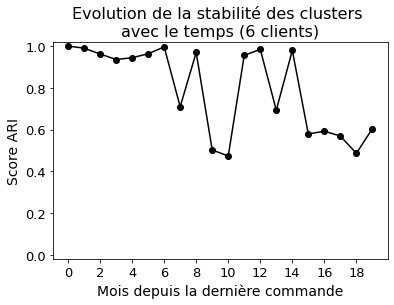

In [77]:
score_ari(cluster_olist_1_6, 0, 19, 6)

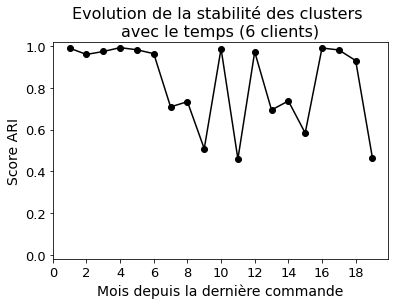

In [78]:
score_ari_pair(cluster_olist_1_6, 0, 19, 6)

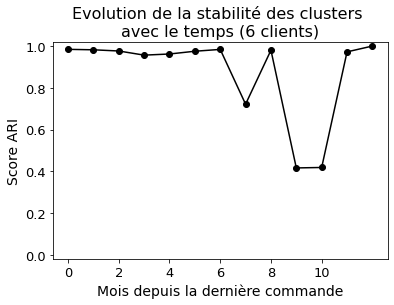

In [79]:
score_ari_time_forward(cluster_olist_1_6, 12, 6)

Nous pouvons voir que le score ARI est stable jusqu'à 6 mois. Au-delà, le score commence à être irrégulier. 
Nous allons étudier les scores Silhouette et Davies-Bouldin afin de vérifier si cette stabilité se confirme ou non.

In [88]:
score_silhouette = []
score_silhouette.append(metrics.silhouette_score(X_olist_fit, model_new_feat_6.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_1, model_6_1.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_2, model_6_2.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_3, model_6_3.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_4, model_6_4.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_5, model_6_5.labels_, random_state=0))

score_silhouette.append(metrics.silhouette_score(X_1_6, model_6_6.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_7, model_6_7.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_8, model_6_8.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_9, model_6_9.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_10, model_6_10.labels_, random_state=0))

score_silhouette.append(metrics.silhouette_score(X_1_11, model_6_11.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_12, model_6_12.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_13, model_6_13.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_14, model_6_14.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_15, model_6_15.labels_, random_state=0))

score_silhouette.append(metrics.silhouette_score(X_1_16, model_6_16.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_17, model_6_17.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_18, model_6_18.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1_19, model_6_19.labels_, random_state=0))

In [89]:
score_davies_bouldin = []
score_davies_bouldin.append(metrics.davies_bouldin_score(X_olist_fit, model_new_feat_6.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_1, model_6_1.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_2, model_6_2.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_3, model_6_3.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_4, model_6_4.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_5, model_6_5.labels_))

score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_6, model_6_6.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_7, model_6_7.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_8, model_6_8.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_9, model_6_9.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_10, model_6_10.labels_))

score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_11, model_6_11.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_12, model_6_12.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_13, model_6_13.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_14, model_6_14.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_15, model_6_15.labels_))

score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_16, model_6_16.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_17, model_6_17.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_18, model_6_18.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1_19, model_6_19.labels_))

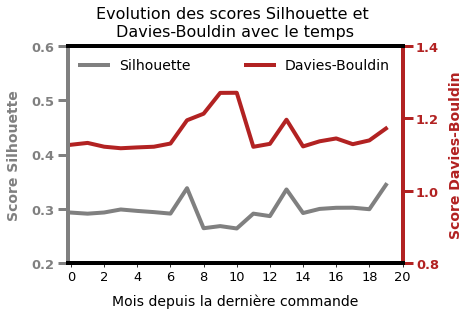

In [102]:
mois = np.arange(0,20,1)

plt.plot(mois, score_silhouette, color="gray", label="Silhouette", linewidth=4)

plt.xlim(-0.2,20)
plt.ylim(0.2,0.6)

plt.xlabel("Mois depuis la dernière commande", fontsize = 14, labelpad=10)
plt.ylabel("Score Silhouette", fontsize = 14, color="gray", weight="bold", labelpad=10)

plt.xticks(np.arange(0,21,2), fontsize = 13)
plt.yticks(np.arange(0.2,0.61,0.1), color="gray", weight="bold")


plt.gca().tick_params(axis="y", width=3, size=10, labelsize=13, labelcolor="gray", 
                      length=10, color="gray")

plt.legend(loc=2, frameon=False, fontsize = 14)

plt.twinx()

plt.plot(mois, score_davies_bouldin, color="firebrick", label="Davies-Bouldin", linewidth=4)

plt.ylabel("Score Davies-Bouldin", fontsize = 14, color="firebrick", weight="bold", labelpad=10)

plt.gca().spines['top'].set_color("black")
plt.gca().spines['top'].set_linewidth(4)
plt.gca().spines['bottom'].set_color("black")
plt.gca().spines['bottom'].set_linewidth(4)
plt.gca().spines['left'].set_color("gray")
plt.gca().spines['left'].set_linewidth(4)
plt.gca().spines['right'].set_color("firebrick")
plt.gca().spines['right'].set_linewidth(4)


plt.yticks(np.arange(0.8,1.6,0.2), color="firebrick", weight="bold")

plt.gca().tick_params(axis="y", width=3, size=10, labelsize=13, labelcolor="firebrick", 
                      length=10, color="firebrick")
plt.xlim(-0.2,20)
plt.ylim(0.8,1.4)

plt.legend(loc=1, frameon=False, fontsize = 14)

plt.title("Evolution des scores Silhouette et \nDavies-Bouldin avec le temps", fontsize = 16, pad=10)

plt.show()

Nous voyons que le fait de considérer les variables RFM engendre une diminution du score ARI 2 mois avant la dernière commande.

Nous allons reproduire une étude similaire mais avec le fichier de maintenance.
<a class="anchor" id="section_2_3"></a>
## Données de maintenance
<a class="anchor" id="section_2_3_1"></a>
### Préparation des données

In [103]:
olist_maintenance = pd.merge(data_olist_pca[["customer_unique_id"]], data_maintenance, on="customer_unique_id", how="left")

display(olist_maintenance.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96441 entries, 0 to 96440
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        96441 non-null  object 
 1   order_id                  96441 non-null  object 
 2   order_purchase_timestamp  96441 non-null  object 
 3   payment_installments      96441 non-null  float64
 4   payment_value             96441 non-null  float64
 5   heure                     96441 non-null  float64
 6   jour                      96441 non-null  float64
 7   jour_semaine              96441 non-null  float64
 8   mois                      96441 non-null  float64
 9   last_commande             96441 non-null  float64
 10  attente_commande          96441 non-null  float64
 11  retard_commande           96441 non-null  float64
 12  nbr_payment               96441 non-null  float64
 13  type_payment              96441 non-null  object 
 14  review

None

In [104]:
olist_maintenance["order_purchase_timestamp"] = pd.to_datetime(olist_maintenance["order_purchase_timestamp"])

In [105]:
olist_maintenance = olist_maintenance.rename(columns={"last_commande" : "recency",
                                                      "order_id" : "frequency",
                                                      "payment_value": "monetary",
                                                      "main_category_order_id" : "main_category"})
last_day_maintenance = (olist_maintenance["order_purchase_timestamp"].max() + datetime.timedelta(days=1)).replace(hour = 0, 
                                                                                                                  minute = 0,
                                                                                                                  second = 0)
display((last_day_maintenance))

Timestamp('2018-08-30 00:00:00')

In [106]:
liste_mois = ["1_mois", "2_mois", "3_mois", "4_mois", "5_mois", "6_mois", "7_mois", "8_mois","9_mois","10_mois",
              "11_mois", "12_mois", "13_mois", "14_mois","15_mois","16_mois", "17_mois", "18_mois", "19_mois"]
d = {}
for i in range (0,19,1):
    d[liste_mois[i]] = olist_maintenance.iloc[:,:21]
    mois = last_day_maintenance - datetime.timedelta(days=30*(i+1))
    d[liste_mois[i]] = d[liste_mois[i]].loc[d[liste_mois[i]]["order_purchase_timestamp"]<mois,:]
    d[liste_mois[i]] = d[liste_mois[i]].groupby("customer_unique_id", 
                                                as_index=False).agg({"order_purchase_timestamp" : "max",
                                                                     "recency" : "min",
                                                                     'frequency' : "count", 
                                                                     'monetary' : "sum",
                                                                     'payment_installments' : "mean",
                                                                     'heure' : "mean",
                                                                     'jour' : "mean",
                                                                     'jour_semaine' : "mean", 
                                                                     'mois' : "mean", 
                                                                     'attente_commande'  : "mean", 
                                                                     'retard_commande' : "mean", 
                                                                     'nbr_payment' : "mean", 
                                                                     'type_payment' : "max", 
                                                                     'review_score' : "mean",
                                                                     'distance_seller_customer' : "mean", 
                                                                     'total_products' : "max", 
                                                                     'vol_product' : "mean",
                                                                     "nbr_category" : "mean",
                                                                     'main_category' : "max", 
                                                                     'product_photos_qty' : "mean"
                                                                    })


In [107]:
colonne = ["payment_installments", 'heure', 'jour_semaine', 'jour', 'mois', 'nbr_payment', "review_score",
           'total_products', "nbr_category", 'product_photos_qty']

for i in range (0,19,1):
    d[liste_mois[i]][colonne] = d[liste_mois[i]][colonne].round(0)
    
    d[liste_mois[i]].loc[(d[liste_mois[i]]["heure"]<18) & (d[liste_mois[i]]["heure"]>=7) , "heure_commande"] = "Working_hours"
    d[liste_mois[i]].loc[(d[liste_mois[i]]["heure"]>=18) | (d[liste_mois[i]]["heure"]<7), "heure_commande"] = "Resting_hours"
    
    d[liste_mois[i]].loc[d[liste_mois[i]]["jour_semaine"]>=5, "work_weekend"] = "Weekend"
    d[liste_mois[i]].loc[d[liste_mois[i]]["jour_semaine"]<5, "work_weekend"] = "Working_days"
    
    d[liste_mois[i]].loc[d[liste_mois[i]]["jour"]<16, "jour_commande"] = "1st_forstnight"
    d[liste_mois[i]].loc[d[liste_mois[i]]["jour"]>=16, "jour_commande"] = "2nd_forstnight"
    
    d[liste_mois[i]].loc[(d[liste_mois[i]]["mois"]==12) | (d[liste_mois[i]]["mois"]==1) | 
                    (d[liste_mois[i]]["mois"]==6) | (d[liste_mois[i]]["mois"]==7), "holidays"] = "Yes"
    d[liste_mois[i]].loc[(d[liste_mois[i]]["mois"]!=12) & (d[liste_mois[i]]["mois"]!=1) & 
                    (d[liste_mois[i]]["mois"]!=6) & (d[liste_mois[i]]["mois"]!=7), "holidays"] = "No"

In [108]:
ohe = OneHotEncoder()
data_olist = {}

for i in range (0,19,1):
    X_object = d[liste_mois[i]][["type_payment", "main_category", "heure_commande", "work_weekend", 
                                 "jour_commande", "holidays"]]
    ohe.fit(X_object)
    codes = ohe.transform(X_object).toarray()
    feature_names = ohe.get_feature_names_out(["type_payment", "main_category", "heure_commande", "work_weekend", 
                                           "jour_commande", "holidays"])
    
    colonne = ["customer_unique_id", "order_purchase_timestamp", "recency", "frequency", "monetary", "total_products", 
               "nbr_category", "nbr_payment",  "payment_installments", "heure", "jour_semaine", "jour", "mois", 
               "attente_commande", "retard_commande", "distance_seller_customer", "product_photos_qty", "review_score", 
               "vol_product"]
    data_olist[liste_mois[i]] = pd.concat([d[liste_mois[i]][colonne], 
                                           pd.DataFrame(codes, columns = feature_names).astype(int)], axis=1)


In [109]:
colonne_log = data_olist['1_mois'].iloc[:,2:].columns.drop(["retard_commande"])

for i in range (0,19,1):
    for col in colonne_log:
        data_olist[liste_mois[i]][col] = np.log10(1 + data_olist[liste_mois[i]][col])

In [110]:
for i in range (0,19,1):
    min_retard = np.abs(1 - (data_olist[liste_mois[i]]["retard_commande"].min()))
    data_olist[liste_mois[i]]["retard_commande"] = np.log10(min_retard + data_olist[liste_mois[i]]["retard_commande"])
    min_retard = 0

In [111]:
for i in range (0,19,1):
    data_olist[liste_mois[i]] = data_olist[liste_mois[i]].sort_values("order_purchase_timestamp").reset_index(drop=True)

In [161]:
X_0 = rob_scale.fit_transform(data_olist_pca[col_client].values)
X_1 = rob_scale.fit_transform(data_olist['1_mois'][col_client].values)
X_2 = rob_scale.fit_transform(data_olist['2_mois'][col_client].values)
X_3 = rob_scale.fit_transform(data_olist['3_mois'][col_client].values)
X_4 = rob_scale.fit_transform(data_olist['4_mois'][col_client].values)
X_5 = rob_scale.fit_transform(data_olist['5_mois'][col_client].values)
X_6 = rob_scale.fit_transform(data_olist['6_mois'][col_client].values)
X_7 = rob_scale.fit_transform(data_olist['7_mois'][col_client].values)
X_8 = rob_scale.fit_transform(data_olist['8_mois'][col_client].values)
X_9 = rob_scale.fit_transform(data_olist['9_mois'][col_client].values)
X_10 = rob_scale.fit_transform(data_olist['10_mois'][col_client].values)
X_11 = rob_scale.fit_transform(data_olist['11_mois'][col_client].values)
X_12 = rob_scale.fit_transform(data_olist['12_mois'][col_client].values)
X_13 = rob_scale.fit_transform(data_olist['13_mois'][col_client].values)
X_14 = rob_scale.fit_transform(data_olist['14_mois'][col_client].values)
X_15 = rob_scale.fit_transform(data_olist['15_mois'][col_client].values)
X_16 = rob_scale.fit_transform(data_olist['16_mois'][col_client].values)
X_17 = rob_scale.fit_transform(data_olist['17_mois'][col_client].values)
X_18 = rob_scale.fit_transform(data_olist['18_mois'][col_client].values)
X_19 = rob_scale.fit_transform(data_olist['19_mois'][col_client].values)

In [162]:
model_6_0 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_0.fit(X_0)

model_6_1 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_1.fit(X_1)

model_6_2 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_2.fit(X_2)

model_6_3 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_3.fit(X_3)

model_6_4 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_4.fit(X_4)

model_6_5 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_5.fit(X_5)

model_6_6 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_6.fit(X_6)

model_6_7 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_7.fit(X_7)

model_6_8 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_8.fit(X_8)

model_6_9 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_9.fit(X_9)

model_6_10 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_10.fit(X_10)

model_6_11 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_11.fit(X_11)

model_6_12 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_12.fit(X_12)

model_6_13 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_13.fit(X_13)

model_6_14 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_14.fit(X_14)

model_6_15 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_15.fit(X_15)

model_6_16 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_16.fit(X_16)

model_6_17 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_17.fit(X_17)

model_6_18 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_18.fit(X_18)

model_6_19 = KMeans(n_clusters = 6, init = "k-means++", random_state = 0)
model_6_19.fit(X_19)

KMeans(n_clusters=6, random_state=0)

In [163]:
data_olist['1_mois']["cluster_6_1"] = pd.Series(model_6_1.labels_)
data_olist['2_mois']["cluster_6_2"] = pd.Series(model_6_2.labels_)
data_olist['3_mois']["cluster_6_3"] = pd.Series(model_6_3.labels_)
data_olist['4_mois']["cluster_6_4"] = pd.Series(model_6_4.labels_)
data_olist['5_mois']["cluster_6_5"] = pd.Series(model_6_5.labels_)
data_olist['6_mois']["cluster_6_6"] = pd.Series(model_6_6.labels_)
data_olist['7_mois']["cluster_6_7"] = pd.Series(model_6_7.labels_)
data_olist['8_mois']["cluster_6_8"] = pd.Series(model_6_8.labels_)
data_olist['9_mois']["cluster_6_9"] = pd.Series(model_6_9.labels_)
data_olist['10_mois']["cluster_6_10"] = pd.Series(model_6_10.labels_)
data_olist['11_mois']["cluster_6_11"] = pd.Series(model_6_11.labels_)
data_olist['12_mois']["cluster_6_12"] = pd.Series(model_6_12.labels_)
data_olist['13_mois']["cluster_6_13"] = pd.Series(model_6_13.labels_)
data_olist['14_mois']["cluster_6_14"] = pd.Series(model_6_14.labels_)
data_olist['15_mois']["cluster_6_15"] = pd.Series(model_6_15.labels_)
data_olist['16_mois']["cluster_6_16"] = pd.Series(model_6_16.labels_)
data_olist['17_mois']["cluster_6_17"] = pd.Series(model_6_17.labels_)
data_olist['18_mois']["cluster_6_18"] = pd.Series(model_6_18.labels_)
data_olist['19_mois']["cluster_6_19"] = pd.Series(model_6_19.labels_)

In [164]:
liste_dataframe_olist_6 = [data_olist_pca[["customer_unique_id", "cluster_6"]],
                           data_olist['1_mois'][["customer_unique_id", "cluster_6_1"]],
                           data_olist['2_mois'][["customer_unique_id", "cluster_6_2"]],
                           data_olist['3_mois'][["customer_unique_id", "cluster_6_3"]],
                           data_olist['4_mois'][["customer_unique_id", "cluster_6_4"]],
                           data_olist['5_mois'][["customer_unique_id", "cluster_6_5"]],
                           data_olist['6_mois'][["customer_unique_id", "cluster_6_6"]],
                           data_olist['7_mois'][["customer_unique_id", "cluster_6_7"]],
                           data_olist['8_mois'][["customer_unique_id", "cluster_6_8"]],
                           data_olist['9_mois'][["customer_unique_id", "cluster_6_9"]],
                           data_olist['10_mois'][["customer_unique_id", "cluster_6_10"]],
                           data_olist['11_mois'][["customer_unique_id", "cluster_6_11"]],
                           data_olist['12_mois'][["customer_unique_id", "cluster_6_12"]],
                           data_olist['13_mois'][["customer_unique_id", "cluster_6_13"]],
                           data_olist['14_mois'][["customer_unique_id", "cluster_6_14"]],
                           data_olist['15_mois'][["customer_unique_id", "cluster_6_15"]],
                           data_olist['16_mois'][["customer_unique_id", "cluster_6_16"]],
                           data_olist['17_mois'][["customer_unique_id", "cluster_6_17"]],
                           data_olist['18_mois'][["customer_unique_id", "cluster_6_18"]],
                           data_olist['19_mois'][["customer_unique_id", "cluster_6_19"]]
                          ]

cluster_olist_6 = reduce(lambda  left,right: pd.merge(left,right,on=['customer_unique_id'],
                                            how='outer'), liste_dataframe_olist_6)

<a class="anchor" id="section_2_3_2"></a>
## Score ARI

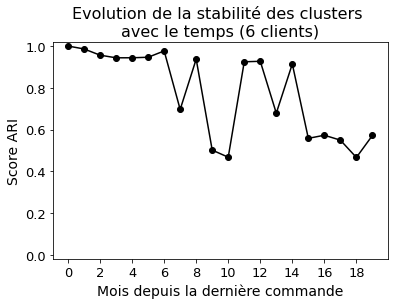

In [165]:
score_ari(cluster_olist_6, 0, 19, 6)

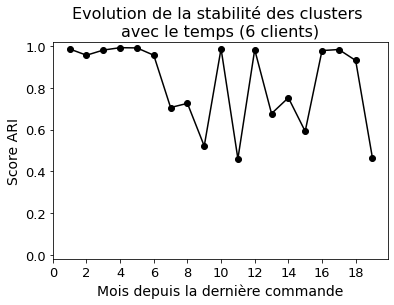

In [166]:
score_ari_pair(cluster_olist_6, 0, 19, 6)

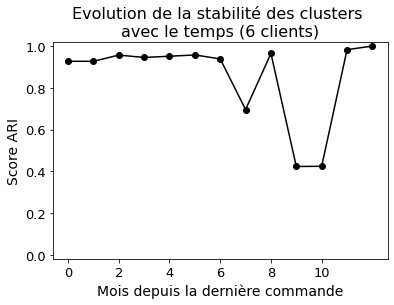

In [175]:
score_ari_time_forward(cluster_olist_6, 12, 6)

Nous voyons que les scores sont identiques avec les deux méthodes choisis ce qui était attendu.

In [171]:
score_silhouette = []
score_silhouette.append(metrics.silhouette_score(X_olist_fit, model_new_feat_6.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_1, model_6_1.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_2, model_6_2.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_3, model_6_3.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_4, model_6_4.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_5, model_6_5.labels_, random_state=0))

score_silhouette.append(metrics.silhouette_score(X_6, model_6_6.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_7, model_6_7.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_8, model_6_8.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_9, model_6_9.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_10, model_6_10.labels_, random_state=0))

score_silhouette.append(metrics.silhouette_score(X_11, model_6_11.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_12, model_6_12.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_13, model_6_13.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_14, model_6_14.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_15, model_6_15.labels_, random_state=0))

score_silhouette.append(metrics.silhouette_score(X_16, model_6_16.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_17, model_6_17.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_18, model_6_18.labels_, random_state=0))
score_silhouette.append(metrics.silhouette_score(X_19, model_6_19.labels_, random_state=0))

In [172]:
score_davies_bouldin = []
score_davies_bouldin.append(metrics.davies_bouldin_score(X_olist_fit, model_new_feat_6.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_1, model_6_1.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_2, model_6_2.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_3, model_6_3.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_4, model_6_4.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_5, model_6_5.labels_))

score_davies_bouldin.append(metrics.davies_bouldin_score(X_6, model_6_6.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_7, model_6_7.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_8, model_6_8.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_9, model_6_9.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_10, model_6_10.labels_))

score_davies_bouldin.append(metrics.davies_bouldin_score(X_11, model_6_11.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_12, model_6_12.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_13, model_6_13.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_14, model_6_14.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_15, model_6_15.labels_))

score_davies_bouldin.append(metrics.davies_bouldin_score(X_16, model_6_16.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_17, model_6_17.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_18, model_6_18.labels_))
score_davies_bouldin.append(metrics.davies_bouldin_score(X_19, model_6_19.labels_))

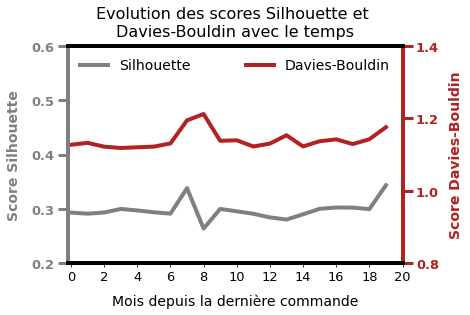

In [173]:
mois = np.arange(0,20,1)

plt.plot(mois, score_silhouette, color="gray", label="Silhouette", linewidth=4)

plt.xlim(-0.2,20)
plt.ylim(0.2,0.6)

plt.xlabel("Mois depuis la dernière commande", fontsize = 14, labelpad=10)
plt.ylabel("Score Silhouette", fontsize = 14, color="gray", weight="bold", labelpad=10)

plt.xticks(np.arange(0,21,2), fontsize = 13)
plt.yticks(np.arange(0.2,0.61,0.1), color="gray", weight="bold")


plt.gca().tick_params(axis="y", width=3, size=10, labelsize=13, labelcolor="gray", 
                      length=10, color="gray")

plt.legend(loc=2, frameon=False, fontsize = 14)

plt.twinx()

plt.plot(mois, score_davies_bouldin, color="firebrick", label="Davies-Bouldin", linewidth=4)

plt.ylabel("Score Davies-Bouldin", fontsize = 14, color="firebrick", weight="bold", labelpad=10)

plt.gca().spines['top'].set_color("black")
plt.gca().spines['top'].set_linewidth(4)
plt.gca().spines['bottom'].set_color("black")
plt.gca().spines['bottom'].set_linewidth(4)
plt.gca().spines['left'].set_color("gray")
plt.gca().spines['left'].set_linewidth(4)
plt.gca().spines['right'].set_color("firebrick")
plt.gca().spines['right'].set_linewidth(4)


plt.yticks(np.arange(0.8,1.6,0.2), color="firebrick", weight="bold")

plt.gca().tick_params(axis="y", width=3, size=10, labelsize=13, labelcolor="firebrick", 
                      length=10, color="firebrick")
plt.xlim(-0.2,20)
plt.ylim(0.8,1.4)

plt.legend(loc=1, frameon = False, fontsize = 14)

plt.title("Evolution des scores Silhouette et \nDavies-Bouldin avec le temps", fontsize = 16, pad = 10)

plt.show()